Completed 1000 episodes.
Completed 2000 episodes.
Completed 3000 episodes.
Completed 4000 episodes.
Completed 5000 episodes.
Completed 6000 episodes.
Completed 7000 episodes.
Completed 8000 episodes.
Completed 9000 episodes.
Completed 10000 episodes.


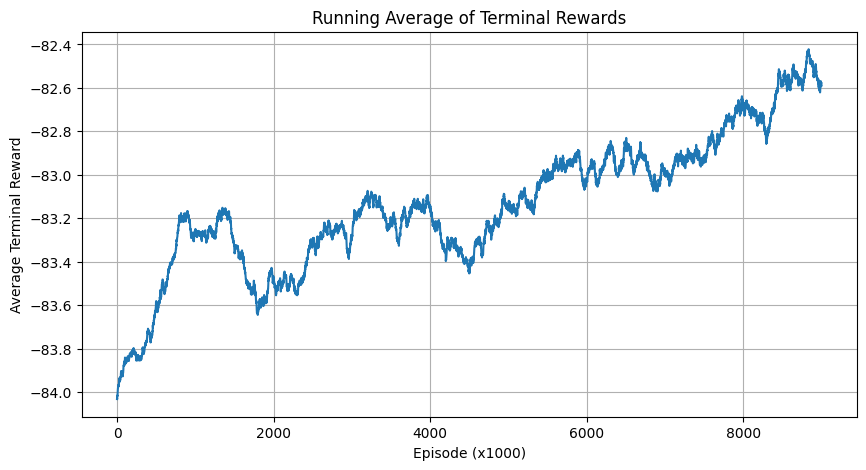


Learned Q–function:
State (0, 10): {0.0: -7.424696646471743e-09, 0.25: -3.834698305906688e-09, 0.5: -4.7190062603269995e-09, 0.75: -2.188312936867516e-09, 1.0: -4.176678885088153e-09}
State (1, 9.0): {0.0: -8.885550488665865e-09, 0.25: -6.719124143152891e-09, 0.5: -2.492406987234363e-08, 0.75: 0.0, 1.0: 0.0}
State (1, 9.375): {0.0: -3.304579522405884e-08, 0.25: -6.0427384474764945e-09, 0.5: -2.445033697645919e-08, 0.75: -1.4780539543179899e-08, 1.0: 0.0}
State (1, 9.75): {0.0: -2.571104596678292e-08, 0.25: -8.110200497172138e-10, 0.5: -1.8735740694114777e-08, 0.75: -2.7167041084954656e-08, 1.0: -3.243264719862853e-08}
State (1, 10.125): {0.0: -8.742789969215097e-09, 0.25: -1.9767970310309196e-08, 0.5: -1.129714894904167e-08, 0.75: -1.4037627738188224e-08, 1.0: 0.0}
State (1, 10.5): {0.0: -2.3073768755435924e-08, 0.25: -2.256666907778102e-08, 0.5: -3.7987240419469645e-09, 0.75: -2.081395098768099e-08, 1.0: -2.0543477263107816e-08}
State (1, 11.625): {0.0: -2.2816272740952177e-08, 0.25:

In [18]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

# --- Environment Definition ---
class AssetAllocEnv:
    """Environment for discrete-time asset allocation with risky and riskless assets."""
    
    def __init__(self, initial_wealth=10, horizon=10):
        """
        Initialize the asset allocation environment.

        Args:
            initial_wealth (float): Starting wealth, defaults to 10.
            horizon (int): Number of time steps, defaults to 10.
        """
        self.initial_wealth = initial_wealth
        self.horizon = horizon
        self.riskless_return = 0.05  # Risk-free rate per time step
        # Risky asset follows a Bernoulli distribution
        self.risky_probs = [0.35, 0.65]   # Probabilities for positive/negative returns
        self.risky_returns = [0.5, -0.1]  # Corresponding returns for risky asset
        self.actions = [0.0, 0.25, 0.5, 0.75, 1.0]  # Possible fractions of wealth to risky asset
        self.reset()

    def reset(self):
        """
        Reset the environment to initial state.

        Returns:
            tuple: Initial state as (time, wealth).
        """
        self.time = 0  # Start at time step 0
        self.wealth = self.initial_wealth
        return (self.time, self.wealth)

    def step(self, action):
        """
        Execute one time step in the environment.

        Args:
            action (float): Fraction of wealth allocated to the risky asset.

        Returns:
            tuple: (next_state, reward, done) where next_state is (time, wealth),
                   reward is the utility at terminal step or 0, and done indicates episode end.
        """
        # Sample risky asset return based on Bernoulli distribution
        idx = np.random.choice(len(self.risky_probs), p=self.risky_probs)
        r_risky = self.risky_returns[idx]
        # Update wealth: risky portion grows by r_risky, riskless by fixed rate
        new_wealth = self.wealth * action * (1 + r_risky) + self.wealth * (1 - action) * (1 + self.riskless_return)
        new_wealth = round(new_wealth, 3)  # Discretize wealth for finite state space
        self.time += 1
        done = (self.time >= self.horizon)  # End at horizon (e.g., t=10)
        # Reward is CARA utility only at terminal step
        reward = self._utility(new_wealth) if done else 0
        self.wealth = new_wealth
        return (self.time, self.wealth), reward, done

    def _utility(self, wealth):
        """
        Compute the CARA utility of wealth.

        Args:
            wealth (float): Current wealth.

        Returns:
            float: Utility value based on risk aversion.
        """
        risk_aversion = 0.01  # Fixed risk aversion parameter
        return (-np.exp(-risk_aversion * wealth)) / risk_aversion

# --- On-Policy SARSA Agent Definition ---
class OnPolicySARSAAgent:
    """SARSA agent for learning optimal asset allocation policy using TD method."""
    
    def __init__(self, env, alpha=0.15, gamma=0.9, epsilon=0.1):
        """
        Initialize the SARSA agent.

        Args:
            env (AssetAllocEnv): Environment instance.
            alpha (float): Learning rate, defaults to 0.15.
            gamma (float): Discount factor, defaults to 0.9.
            epsilon (float): Exploration probability, defaults to 0.1.
        """
        self.env = env
        self.alpha = alpha      # Step size for Q-value updates
        self.gamma = gamma      # Discount factor for future rewards
        self.epsilon = epsilon  # Probability of random action in epsilon-greedy
        self.actions = env.actions
        # Q-table maps state (time, wealth) to action-value dictionary
        self.Q = {}

    def _state_key(self, state):
        """
        Convert state to a hashable key for Q-table.

        Args:
            state (tuple): (time, wealth).

        Returns:
            tuple: Same as input, used as dictionary key.
        """
        return state

    def get_Q(self, state, action):
        """
        Get Q-value for a state-action pair, initializing if not present.

        Args:
            state (tuple): (time, wealth).
            action (float): Action taken.

        Returns:
            float: Q-value, 0 if uninitialized.
        """
        key = self._state_key(state)
        if key not in self.Q:
            self.Q[key] = {a: 0.0 for a in self.actions}  # Initialize all actions to 0
        return self.Q[key][action]

    def set_Q(self, state, action, value):
        """
        Set Q-value for a state-action pair.

        Args:
            state (tuple): (time, wealth).
            action (float): Action taken.
            value (float): New Q-value.
        """
        key = self._state_key(state)
        if key not in self.Q:
            self.Q[key] = {a: 0.0 for a in self.actions}
        self.Q[key][action] = value

    def choose_action(self, state):
        """
        Select an action using epsilon-greedy policy.

        Args:
            state (tuple): Current state (time, wealth).

        Returns:
            float: Chosen action.
        """
        key = self._state_key(state)
        if key not in self.Q:
            self.Q[key] = {a: 0.0 for a in self.actions}
        # Explore with probability epsilon, else exploit best action
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        return max(self.Q[key], key=lambda a: self.Q[key][a])

    def run_episode(self):
        """
        Run one episode of SARSA, updating Q-values.

        Returns:
            float: Terminal reward from the episode.
        """
        state = self.env.reset()
        action = self.choose_action(state)
        terminal_reward = None
        done = False
        while not done:
            next_state, reward, done = self.env.step(action)
            if done:
                # Terminal update: Q(s,a) += alpha * (reward - Q(s,a))
                current_val = self.get_Q(state, action)
                td_target = reward
                new_val = current_val + self.alpha * (td_target - current_val)
                self.set_Q(state, action, new_val)
                terminal_reward = reward
                break
            # Non-terminal update: Q(s,a) += alpha * (r + gamma*Q(s',a') - Q(s,a))
            next_action = self.choose_action(next_state)
            current_val = self.get_Q(state, action)
            next_val = self.get_Q(next_state, next_action)
            td_target = reward + self.gamma * next_val
            new_val = current_val + self.alpha * (td_target - current_val)
            self.set_Q(state, action, new_val)
            state, action = next_state, next_action
        return terminal_reward

    def train(self, num_episodes=10000):
        """
        Train the agent over multiple episodes.

        Args:
            num_episodes (int): Number of episodes to run, defaults to 10000.

        Returns:
            list: Terminal rewards for each episode.
        """
        terminal_rewards = []
        for ep in range(1, num_episodes + 1):
            tr = self.run_episode()
            terminal_rewards.append(tr)
            if ep % 1000 == 0:
                print(f"Completed {ep} episodes.")
        return terminal_rewards

    def optimal_policy(self):
        """
        Extract the optimal policy from the learned Q-function.

        Returns:
            dict: Maps states to optimal actions (greedy policy).
        """
        policy = {}
        for state, actions in self.Q.items():
            best_action = max(actions, key=actions.get)  # Greedy action
            policy[state] = best_action
        return policy

# --- Function for Running Average ---
def running_average(data, window_size=1000):
    """
    Compute the running average of a data sequence.

    Args:
        data (list): Sequence of values.
        window_size (int): Size of the averaging window, defaults to 1000.

    Returns:
        np.ndarray: Running average array.
    """
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# --- Main Training, Visualization, and Policy Extraction ---
if __name__ == '__main__':
    # Set up environment and agent with specific hyperparameters
    env = AssetAllocEnv(initial_wealth=10, horizon=10)
    agent = OnPolicySARSAAgent(env, alpha=0.1, gamma=0.9, epsilon=0.1)
    
    # Train and collect rewards
    rewards = agent.train(num_episodes=10000)
    
    # Visualize learning progress with running average
    avg_rewards = running_average(rewards, window_size=1000)
    plt.figure(figsize=(10, 5))
    plt.plot(avg_rewards)
    plt.xlabel("Episode (x1000)")
    plt.ylabel("Average Terminal Reward")
    plt.title("Running Average of Terminal Rewards")
    plt.grid(True)
    plt.show()
    
    # Display learned Q-function
    print("\nLearned Q–function:")
    for state, actions in sorted(agent.Q.items()):
        print(f"State {state}: {actions}")
